In [1]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\sensio\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Basic use

We want to solve the following PDE:

\begin{equation}
    \frac{\partial \phi}{\partial t} + u \frac{\partial \phi}{\partial x} = 0
\end{equation}

The independent variables (i.e, $x$ and $t$) are used as input values for the NN, and the solution (i.e. $\phi$) is the output. In order to find the solution, at each step the NN outputs are derived w.r.t the inputs. Then, a loss function that matches the PDE is built and the weights are updated accordingly. If the loss function goes to zero, we can assume that our NN is indeed the solution to our PDE. We will try to find a general solution for different values of $u$, so it will be set also as an input.

In [2]:
# imports
import numpy as np 
import matplotlib.pyplot as plt 
import nangs
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('0.1.0', '1.5.0')

## Define your data

To solve the PDE we first need a set of points to evaluate it, we will use this points as the dataset for training de NN.

In [3]:
# define the mesh
x = np.linspace(0,1,20)
t = np.linspace(0,1,30)
u = np.linspace(-1,1,10)

The class `Mesh` will combine all the posible values on the previous arrays to build a mesh. You must pass the data as a dict, providing one (unique) name for each variable.

In [4]:
from nangs import Mesh

mesh = Mesh({'x': x, 't': t, 'u': u})
mesh.vars

['x', 't', 'u']

In order to train a NN we need a `Dataset`. A `Mesh` has in fact a `Dataset` that you can iterate over.

In [5]:
len(mesh.dataset)

6000

In [6]:
mesh.dataset[:3]

tensor([[ 0.0000,  0.0000, -1.0000],
        [ 0.0000,  0.0000, -0.7778],
        [ 0.0000,  0.0000, -0.5556]])

You can also specify the device to cache the data

In [7]:
mesh = Mesh({'x': x, 't': t, 'u': u}, device=device)
mesh.dataset[:3]

tensor([[ 0.0000,  0.0000, -1.0000],
        [ 0.0000,  0.0000, -0.7778],
        [ 0.0000,  0.0000, -0.5556]], device='cuda:0')

## Define your solution topology

To facilitate the definition of a NN to approximate the PDE solution, we provide the class `MLP`, that will build a Multilayer Perceptron.

In [8]:
from nangs import MLP

n_inputs = len(mesh.vars)
n_outputs = 1
n_layers = 3
h_dim = 100

mlp = MLP(n_inputs, n_outputs, n_layers, h_dim)
mlp

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): Sequential(
      (0): Sine()
      (1): Linear(in_features=100, out_features=100, bias=True)
    )
    (2): Sequential(
      (0): Sine()
      (1): Linear(in_features=100, out_features=100, bias=True)
    )
    (3): Sequential(
      (0): Sine()
      (1): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)

This class will build an MLP with the specified number of inputs, outputs, layers and neurons in the hidden layers and the same activiation function. You can always build your own custom NN.

## Boundary Conditions

We can attempt to solve our PDE at this points, but we would obtain a trivial solution. Instead, we need to specify a set of boundary conditions. Nangs provide different classes for common boundary conditions.

In [9]:
# initial condition (t = 0)

t0 = np.array([0])
_x, _t, _u = np.meshgrid(x, t0, u)
p0 = np.sin(2*np.pi*(_x- _u*_t))
p0.shape

(1, 20, 10)

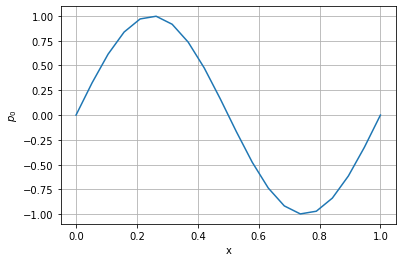

In [10]:
plt.plot(x, p0[0,:,0])
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$p_0$')
plt.show()

A boundary condition has its own `Mesh` and logic to compute values and gradients. In a `Dirichlet` boundary conditions we are fixing some values, so we need the inputs and also the target outputs (in this case, our initial condition). If you are including some free-parameters as NN inputs, make sure you specify an initial condition for each one of them (here we use the same for every value of $u$).

In [11]:
from nangs import Dirichlet

initial_condition = Dirichlet({'x': x, 't': t0, 'u': u}, {'p': p0.reshape(-1)}, device=device)
initial_condition.vars

[['x', 't', 'u'], ['p']]

In [12]:
initial_condition.dataset[:5]

(tensor([[ 0.0000,  0.0000, -1.0000],
         [ 0.0000,  0.0000, -0.7778],
         [ 0.0000,  0.0000, -0.5556],
         [ 0.0000,  0.0000, -0.3333],
         [ 0.0000,  0.0000, -0.1111]], device='cuda:0'),
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.]], device='cuda:0'))

We use a periodic boundary condition at $x=0$ and $x=1$. During training we will enforce this values to match.

In [13]:
# boundary conditions (peridic conditions at x = 0 and x = 1)

xb0 = np.array([0])
mb0 = np.meshgrid(xb0, t)
mb0 = np.stack(mb0, -1).reshape(-1, 2)
mb0.shape

(30, 2)

In [14]:
from nangs import Periodic

x1 = np.array([0.])
x2 = np.array([1.])
periodic = Periodic({'x': x1, 't': t, 'u': u}, {'x': x2, 't': t, 'u': u}, device=device)
periodic.vars

[['x', 't', 'u'], ['x', 't', 'u']]

In [15]:
periodic.dataset[:5]

(tensor([[ 0.0000,  0.0000, -1.0000],
         [ 0.0000,  0.0000, -0.7778],
         [ 0.0000,  0.0000, -0.5556],
         [ 0.0000,  0.0000, -0.3333],
         [ 0.0000,  0.0000, -0.1111]], device='cuda:0'),
 tensor([[ 1.0000,  0.0000, -1.0000],
         [ 1.0000,  0.0000, -0.7778],
         [ 1.0000,  0.0000, -0.5556],
         [ 1.0000,  0.0000, -0.3333],
         [ 1.0000,  0.0000, -0.1111]], device='cuda:0'))

## Solve the PDE

We provide the class `Solver` with the default functionality to solve the PDE. You must initialize this class with your NN, an optimizer and a criterion to compute the loss function (you can also pass a scheduler as an optional argument). Then, you can solve your PDE by calling the `solve` method on the `Solver`. You must pass the `dataloaders` as a `dict` with a `mesh` key with your mesh and a `bocos` key containing another `dict` with all your bocos. You can also set the number of epochs as an additional (optional) parameter.

In [16]:
from nangs import Solver

class MySolver(Solver):
    def computePDELoss(self, inputs, outputs):
        # compute gradients
        grads, = torch.autograd.grad(outputs, inputs,
                        grad_outputs=outputs.data.new(outputs.shape).fill_(1),
                        create_graph=True, only_inputs=True)
        # compute loss
        dpdx, dpdt = grads[:, 0], grads[:, 1]
        u = inputs[:, 2]
        pde = dpdt + u*dpdx
        return pde.pow(2).mean()

In [17]:
BATCH_SIZE = 256
LR = 1e-2
EPOCHS = 40
NUM_LAYERS = 3
NUM_HIDDEN = 128

mlp = MLP(len(mesh.vars), 1, NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, total_steps=EPOCHS)

solver = MySolver()
solver.compile(mlp, optimizer, criterion, scheduler)
hist = solver.solve(mesh, bocos=[initial_condition, periodic], epochs=EPOCHS, batch_size=BATCH_SIZE)

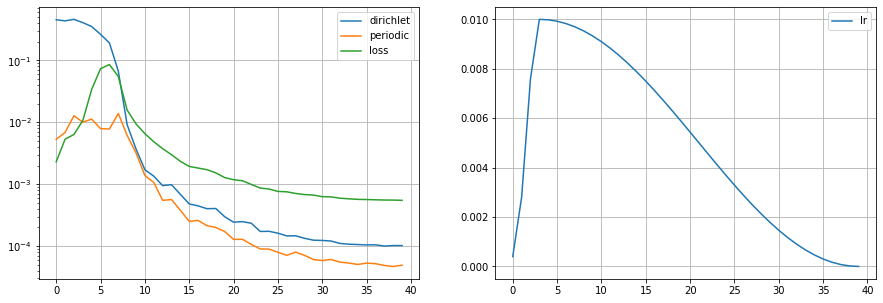

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
for name, vale in hist.items():
    if name is not 'lr':
        ax1.plot(hist[name], label=name)
ax1.grid(True)
ax1.legend()
ax1.set_yscale("log")
ax2.plot(hist['lr'], label='lr')
ax2.grid(True)
ax2.legend()
plt.show()

## Evaluate your solution

In [19]:
from matplotlib import animation, rc
rc('animation', html='html5')

def update_plot(i, x, u, t, p):
    ax.clear()
    pe = np.sin(2.*np.pi*(x-u*t[i]))
    ax.plot(x, pe, label=f"exact (u = {U})")
    ax.plot(x, p[i], '.k', label="solution")
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("p", fontsize=14, rotation=np.pi/2)
    ax.legend(loc="upper right")
    ax.grid(True)
    ax.set_xlim([0, 1])
    ax.set_ylim([-1.2, 1.2])
    l2 = np.sqrt(np.sum((p[i]-pe)**2))
    ax.set_title(f"t = {t[i]:.3f} (L2 = {l2:.5f})")
    return ax

In [20]:
#t = np.linspace(0,1,10)
U = -0.5

x = np.linspace(0,1,30)
t = np.linspace(0,1,20)
u = np.array([U])
eval_mesh = Mesh({'x': x, 't': t, 'u': u}, device=device)

p = solver.eval(eval_mesh)
p = p.cpu().numpy().reshape(len(t), -1)

fig = plt.figure()
ax = plt.subplot(111)
anim = animation.FuncAnimation(fig, update_plot, frames=len(t), fargs=(x, U, t, p), interval=300)
plt.close()

In [21]:
anim